In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MIMIC III Code Prediction

> API details

In [ ]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports

In [ ]:
from fastai.text.all import *
from fastai.distributed import *

from xcube.text.learner import text_classifier_learner
from xcube.metrics import PrecisionK

#### Setting the base path as the path of the repository

In [ ]:
path = Path.cwd()
path_data = path/'data'
path_model = path/'models'

path, path_data, path_model

(Path('/home/deb/xcube/nbs/examples/mimic'),
 Path('/home/deb/xcube/nbs/examples/mimic/data'),
 Path('/home/deb/xcube/nbs/examples/mimic/models'))

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Mimic-III (the one we prepared in the notebook 01_data_extraction2). Here we will build the `DataLoaders` object using the `DataBlock` API:

In [ ]:
df = pd.read_csv(path_data/'caml_notes_labelled.csv',
                dtype={'text': str, 'labels': str, 'subject_id': np.int64, 'hadm_id': np.int64})

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype('str')

Let's take a look at the data:

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


We will now create the `DataLoaders` using `DataBlock` API:

In [ ]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True, max_vocab=51920),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [ ]:
dls_lm.show_batch(max_n=2)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,xxbos admission date discharge date date of birth sex m service medicine allergies ace inhibitors attending first name3 lf chief complaint shortness of breath red tinged sputum production major surgical or invasive procedure bedside bronchoscopy with bronchoalveolar lavage xxunk intubation and ventilation nasogastric tube placement history of present illness this is a year old first name3 lf speaking male with h o dm infarct related cardiomyopathy chf most recent ef of in month only nadir of cad s p cabg,admission date discharge date date of birth sex m service medicine allergies ace inhibitors attending first name3 lf chief complaint shortness of breath red tinged sputum production major surgical or invasive procedure bedside bronchoscopy with bronchoalveolar lavage xxunk intubation and ventilation nasogastric tube placement history of present illness this is a year old first name3 lf speaking male with h o dm infarct related cardiomyopathy chf most recent ef of in month only nadir of cad s p cabg x
1,remained stable through the rest of her stay and did not require further blood transfusions afib with rvr patient with known afib in setting of hypotension and tachycardia patient was xxunk diltiazem drip for rate control originally the patient s tachycardia resolved and the patient was transitioned back to her normal regimen of dilt 30 mg po hospital unit name and metoprolol 25 mg po tid the patient was on 3 mg coumadin on admission with therapeutic inr which was,stable through the rest of her stay and did not require further blood transfusions afib with rvr patient with known afib in setting of hypotension and tachycardia patient was xxunk diltiazem drip for rate control originally the patient s tachycardia resolved and the patient was transitioned back to her normal regimen of dilt 30 mg po hospital unit name and metoprolol 25 mg po tid the patient was on 3 mg coumadin on admission with therapeutic inr which was held


The length of our vocabulary is:

In [ ]:
len(dls_lm.vocab)

51928

Let's take a look at some words of the vocab:

In [ ]:
coll_repr(L(dls_lm.vocab), 30)

"(#51928) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]"

Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use):

In [ ]:
torch.save(dls_lm, path_model/'caml_dls_lm.pkl')

To load back the `dls_lm` later on:

In [ ]:
dls_lm = torch.load(path_model/'caml_dls_lm.pkl')

In [ ]:
torch.save(dls_lm.vocab, path_model/'caml_dls_lm_vocab.pkl')

## `Learner` for the Language Model Fine-Tuning:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

Let's compute the learning rate using the `lr_find`:

(0.13182567358016967,
 0.03981071710586548,
 0.004365158267319202,
 0.02754228748381138)

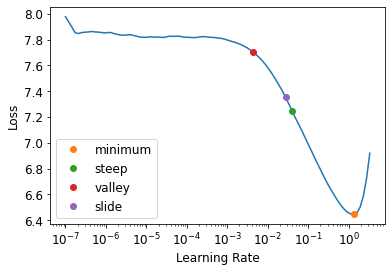

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.055411,2.889091,0.463165,17.976971,21:32


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

In [ ]:
learn.save(path_model/'caml_lm_recent')

Path('/home/deb/xcube/nbs/examples/mimic/models/caml_lm_recent.pth')

Let's now load back the `Learner`

In [ ]:
learn = learn.load(path_model/'caml_lm')

Let's validate the `Learner` to make sure we loaded the correct version:

In [ ]:
learn.validate()

(#3) [2.1801044940948486,0.551633358001709,8.847230911254883]

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname=path_model/'caml_lm'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.700497,2.601790,0.498114,13.487859,21:50
1,2.532751,2.447730,0.516926,11.562066,21:53
2,2.438119,2.364874,0.527396,10.642694,21:45
3,2.373062,2.317114,0.533622,10.146353,21:37
4,2.315276,2.284130,0.538038,9.817142,21:30
5,2.294005,2.259134,0.541297,9.574790,21:33
6,2.244216,2.240372,0.544038,9.396826,21:33
7,2.236868,2.227880,0.546116,9.280175,21:30
8,2.209610,2.221307,0.547150,9.219376,21:31
9,2.166203,2.220918,0.547269,9.215789,21:37


Better model found at epoch 0 with valid_loss value: 2.601789951324463.
Better model found at epoch 1 with valid_loss value: 2.4477295875549316.
Better model found at epoch 2 with valid_loss value: 2.3648736476898193.
Better model found at epoch 3 with valid_loss value: 2.3171143531799316.
Better model found at epoch 4 with valid_loss value: 2.284130096435547.
Better model found at epoch 5 with valid_loss value: 2.2591335773468018.
Better model found at epoch 6 with valid_loss value: 2.2403719425201416.
Better model found at epoch 7 with valid_loss value: 2.2278804779052734.
Better model found at epoch 8 with valid_loss value: 2.2213072776794434.
Better model found at epoch 9 with valid_loss value: 2.2209181785583496.


Note: Make sure if you have trained the most language model `Learner` for more epochs (then you need to save that version)

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [ ]:
learn.save_encoder(path_model/'caml_lm_finetuned')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-level Data API):

We will now move from language model fine-tuning to calssifier fine-tuning. In notebook 02_code_prediction2.ipynb we used the `DataBlock` API to built the Multi-Label Classifier `DataLoaders` object. In this notebook though we will build it using the Mid-Level Data API:

### Loading Raw Data

Let's load the Dataframe (stored in file: notes_labelled.csv) that we created in notebook 01_data_extraction2.ipynb:

In [ ]:
!tree -L 1 {path} 

/home/deb/xcube/nbs/examples/mimic
├── data
├── mimic3_data_extraction.ipynb
├── mimic3_full_prediction.ipynb
├── mimic3_sample_prediction.ipynb
├── models
├── train_mimic.py
├── train_mimic_old.py
└── xcube -> /home/deb/xcube/xcube

3 directories, 5 files


Aside: Some handy linux find tricks:
1. https://stackoverflow.com/questions/18312935/find-file-in-linux-then-report-the-size-of-file-searched
2. https://stackoverflow.com/questions/4210042/how-to-exclude-a-directory-in-find-command

In [ ]:
# !find -path ./models -prune -o -type f -name "*caml*" -exec du -sh {} \;
!find -not -path "./data/*" -type f -name "*caml*" -exec du -sh {} \;
# !find {path_data} -type f -name "*caml*" | xargs du -sh

1008K	./models/caml_dls_lm_vocab.pkl
1.2G	./models/caml_dls_lm_recent.pkl
539M	./models/caml_after_warmup_sample.pth
165M	./models/caml_dls_clas_sample_10percent_32.pkl
1.2G	./models/caml_dls_lm.pkl
180M	./models/caml_clas_sample_10percent.pth
180M	./models/caml_after3_sample.pth
912K	./models/caml_dls_lm_vocab_recent.pkl
193M	./models/caml_clas_full.pth
165M	./models/caml_dls_clas_sample_10percent_64.pkl
1.6G	./models/caml_dls_clas_full_16.pkl
157M	./models/caml_lm_finetuned_recent.pth
165M	./models/caml_dls_clas_sample_10percent_16.pkl
165M	./models/caml_dls_clas_sample_10percent_128.pkl
166M	./models/caml_lm.pth
165M	./models/caml_lm_finetuned.pth
157M	./models/caml_lm_recent.pth


If you are loading the sample dataset use the cell below:

In [ ]:
data_file = path_data/'caml_notes_labelled.csv'
lm_vocab_file = path_model/'caml_dls_lm_vocab.pkl'

In [ ]:
df =pd.read_csv(data_file, dtype= {
    'text': str,
    'labels': str,
    'subject_id': np.int64,
    'hadm_id': np.int64
})

We need to convert the datatypes of the required columns, `text` and `labels`, to str:

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype('str')

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


let's now gather the labels from the 'labels' column of the df:

In [ ]:
label_freq = Counter()
for labels in df.labels: label_freq.update(labels.split(';'))

The total number of labels are:

In [ ]:
len(label_freq)

8922

Let's take a look at the most common labels:

In [ ]:
pd.DataFrame(label_freq.most_common(20), columns=['label', 'frequency'])

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179
5,96.04,9932
6,96.6,9161
7,584.9,8907
8,250.00,8784
9,96.71,8619


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = list(label_freq.keys()) 

### Steps for creating the classifier `DataLoaders` using fastai `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [ ]:
splits = [train, valid] = splitter(df)

In [ ]:
L(splits[0]), L(splits[1])

((#49354) [0,1,2,3,4,5,6,7,8,9...],
 (#3372) [1631,1632,1633,1634,1635,1636,1637,1638,1639,1640...])

#### 2. Define transforms for the independent and the dependent variable:

##### a) Transforms for independent variable:

We will now `Tokenize` and `Numericalize` the `text` column of the `df`. 

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use:

So let's load the vocab of the language model:

In [ ]:
lm_vocab = torch.load(path_model/'dls_lm_vocab.pkl')

In [ ]:
L(lm_vocab)

(#60008) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','*'...]

**Crucial**: This is where we pass the `lm_vocab` to the `Numericalize`:

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]

In [ ]:
# tls_x = TfmdLists(df, x_tfms, splits=splits)

In [ ]:
# len(tls_x.train), len(tls_x.valid)

In [ ]:
# a_text = tls_x.train[5]

In [ ]:
# a_text

In [ ]:
# print(tls_x.decode(a_text)[:200])

---

###### Sidebar: Practice Transforms:

`MultiCategorize`

In [ ]:
cat = MultiCategorize()

In [ ]:
lbls = [['b', 'c'], ['a'], ['a', 'c']]

In [ ]:
cat.setup(lbls)

In [ ]:
cat.vocab

['a', 'b', 'c']

In [ ]:
c = cat(lbls[0])
c

TensorMultiCategory([1, 2])

In [ ]:
cat.vocab.map_ids(c)

(#2) ['b','c']

In [ ]:
cat = MultiCategorize()
tds = TfmdLists([['b', 'c'], ['a'], ['a', 'c'], []], tfms=[cat])

In [ ]:
tds.vocab

['a', 'b', 'c']

In [ ]:
tds[0]

TensorMultiCategory([1, 2])

In [ ]:
tds[1]

TensorMultiCategory([0])

In [ ]:
tds[2]

TensorMultiCategory([0, 2])

In [ ]:
tds[3]

TensorMultiCategory([])

`OneHotEncode`

In [ ]:
_tfm = OneHotEncode(c=3)

In [ ]:
_tfm

OneHotEncode -- {'c': 3}:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes

In [ ]:
_tfm([0])

TensorMultiCategory([1., 0., 0.])

In [ ]:
_tfm([1])

TensorMultiCategory([0., 1., 0.])

In [ ]:
_tfm([2])

TensorMultiCategory([0., 0., 1.])

In [ ]:
_tfm([0,1])

TensorMultiCategory([1., 1., 0.])

In [ ]:
_tfm([4])

IndexError: index 4 is out of bounds for dimension 0 with size 3

In [ ]:
tfms = [MultiCategorize(), OneHotEncode()]
tds = TfmdLists([['b', 'c'], ['a'], ['a', 'c'], []], tfms)

In [ ]:
tds.vocab

['a', 'b', 'c']

In [ ]:
tds[0]

TensorMultiCategory([0., 1., 1.])

In [ ]:
tds[1]

TensorMultiCategory([1., 0., 0.])

In [ ]:
tds[2]

TensorMultiCategory([1., 0., 1.])

`ColReader`

In [ ]:
df = pd.DataFrame({
    'a': 'a b c d'.split(),
    'b': ['1 2', '0', '', '1 2 3']
})
df

,a,b
0,a,1 2
1,b,0
2,c,
3,d,1 2 3


In [ ]:
f = ColReader('a', pref='0', suff='1')

In [ ]:
[o for o in df.itertuples()]

[Pandas(Index=0, a='a', b='1 2'),
 Pandas(Index=1, a='b', b='0'),
 Pandas(Index=2, a='c', b=''),
 Pandas(Index=3, a='d', b='1 2 3')]

In [ ]:
[f(o) for o in df.itertuples()]

['0a1', '0b1', '0c1', '0d1']

In [ ]:
f = ColReader('b', label_delim=' ')

In [ ]:
[f(o) for o in df.itertuples()]

[['1', '2'], ['0'], [], ['1', '2', '3']]

---

##### b) Transforms for the dependent variable:

In [ ]:
L(lbls)

(#8922) ['038.9','785.59','584.9','427.5','410.71','428.0','682.6','425.4','263.9','96.04'...]

In [ ]:
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]

In [ ]:
df.head(1)

,subject_id,hadm_id,text,labels,is_valid
0,3,145834,"Admission Date: [**2101-10-20**] Discharge Date: [**2101-10-31**]\n\nDate of Birth: [**2025-4-11**] Sex: M\n\nService: Medicine\n\nCHIEF COMPLAINT: Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented a...",038.9;785.59;584.9;427.5;410.71;428.0;682.6;425.4;263.9;96.04;99.62;89.64;96.72;38.93;96.6,False


In [ ]:
tls_y = TfmdLists(df, y_tfms, splits=splits)

In [ ]:
len(tls_y.train), len(tls_y.valid)

(49354, 3372)

In [ ]:
a_label = tls_y.train[0]
a_label

TensorMultiCategory([1., 1., 1.,  ..., 0., 0., 0.])

In [ ]:
tls_y.vocab

['038.9', '785.59', '584.9', '427.5', '410.71', '428.0', '682.6', '425.4', '263.9', '96.04', '99.62', '89.64', '96.72', '38.93', '96.6', '042', '136.3', '799.4', '276.3', '790.7', '571.5', '041.11', 'V09.0', 'E931.7', '88.72', '33.23', '403.91', '444.0', '997.2', '276.6', '276.7', '285.9', '275.3', 'V15.82', '55.69', '91.0', '39.57', '38.06', '99.04', '431', '507.0', '276.5', '401.9', 'V30.00', '774.2', '765.25', '765.15', 'V29.0', '99.83', '99.15', '191.3', '15.9', '11.3', '92.29', '99.25', '157.0', '574.10', '997.1', '998.11', '568.0', '553.21', 'E878.2', '51.37', '52.12', '54.59', '53.51', '99.60', '54.12', '96.71', '414.01', '411.1', '250.00', '272.0', '36.12', '36.15', '39.61', '37.61', '423.9', '511.9', '785.51', '458.9', '311', '722.0', '719.46', '272.4', '37.31', '745.5', '458.29', 'V12.59', '35.71', '250.80', '780.39', '296.33', 'V58.67', 'E932.3', 'V58.69', '478.29', '780.57', '783.21', '426.4', 'V17.0', '93.9', '89.14', '94.25', '805.02', '599.0', '596.4', 'E880.9', '822.0',

In [ ]:
len(tls_y.vocab)

8922

There are 3 ways of decoding this:

In [ ]:
tls_y.decode(a_label)

(#15) ['038.9','785.59','584.9','427.5','410.71','428.0','682.6','425.4','263.9','96.04'...]

In [ ]:
show_at(tls_y.train, 0)

038.9;785.59;584.9;427.5;410.71;428.0;682.6;425.4;263.9;96.04;99.62;89.64;96.72;38.93;96.6


In [ ]:
tls_y.vocab[torch.where(a_label == 1)[0]]

(#15) ['038.9','785.59','584.9','427.5','410.71','428.0','682.6','425.4','263.9','96.04'...]

#### 3. Making the `Datasets` object:

In [ ]:
lm_vocab = torch.load(lm_vocab_file)

In [ ]:
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]

In [ ]:
dsets = Datasets(df, tfms, splits=splits)

Let's now check if our `Datasets` got created alright:

In [ ]:
len(dsets.train), len(dsets.valid)

(49354, 3372)

In [ ]:
dsets.train[0]

In [ ]:
dsets.decode(dsets.train[0])

In [ ]:
dsets.show(dsets.train[0])

Looks fine!

#### 4. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size:

In [ ]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [ ]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [ ]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                        dl_type=dl_type,
                       before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so let's save it:

In [ ]:
torch.save(dls_clas, path_model/'caml_dls_clas_full_8.pkl')

In [ ]:
dls_clas = torch.load(path_model/'caml_dls_clas_full_16.pkl')

Let's take a look at the data:

In [ ]:
dls_clas.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos admission date discharge date service cardiothoracic allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint doe fatigue and decreased exercise tolerance major surgical or invasive procedure redo sternotomy avr 21 mm company mosaic porcine valve mvr mm company mosaic porcine valve history of present illness yo female with prior cabg in since then she has developed increasing doe fatigue and decreased ability to tolerate activity echo revealed severe as and mr initially seen by dr last name stitle and now presents for surgical repair past medical history cabg x dr last name stitle cad as mr last name titles lipids htn gerd oncogenic osteomalacia lv diastolic dysfunction hereditary hypophosphatemic rickets bil hip surgeries with left thr prior bladder suspension prior tah prior cataract surgery social history retired homemaker never used tobacco denies etoh lives with husband family history not known physical exam,401.9;V43.64;V45.81;272.4;599.0;96.6;530.81;39.61;780.39;041.04;997.02;35.21;396.2;35.23;348.39;89.6;270.0
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,96.71;38.93;96.04;428.0;507.0;599.0;96.6;440.24;88.48;496;99.15;14.0;43.11;482.41;39.29;707.15;38.18;997.2;444.21;97.01;38.03
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,427.89;305.1;599.0;785.52;995.92;584.9;296.80;042;304.01;041.6;V12.04;008.45;332.0;038.8;348.39;304.21


In [ ]:
# x, y = dls_clas.one_batch()

In [ ]:
# x.shape, y.shape

In [ ]:
# len(dls_clas.vocab[0])

In [ ]:
# x[20], len(x[20])

In [ ]:
# print(' '.join([dls_clas.vocab[0][o] for o in x[1]]))

In this section we will unwrap fastai's `text_classifier_learner` and manually write all the steps (ofcourse, shamelessly stealing) from fastai's source code!

To create a `Learner` from scratch we need two things:
- `DataLoaders` `dls`
- an architecture `arch` for the `model`

We already have our `dls` ready from the previous section, so let's focus on creating our architecture.

## `Learner` for Multi-Label Classifier Fine-Tuning (Frozen)

In [ ]:
dls_clas = torch.load(path_model/'dls_clas_full_64.pkl')
# dls_clas = torch.load(path_model/'dls_clas_sample_64.pkl')

### Architecture Creation:

To create an architecture that we can use to build a `model` we need to unwrap fastai's `get_text_classifier`. Let's do that: 

In [ ]:
# model = get_text_classifier(AWD_LSTM,
#                             len(vocab),
#                             n_out,
#                             seq_len=seq_len,
#                             config=config,
#                             y_range=y_range,
#                             drop_mult=drop_mult,
#                             lin_ftrs=lin_ftrs,
#                             max_len=max_len)

The following is a dictionary where keys are the well known (possibly pretarianed) NLP architectures and values are the configurations, urls (where we can download the pretrained weights from) and other info we need to create that architecture:

In [ ]:
_model_meta = {
    AWD_LSTM: {'hid_name':'emb_sz', 'url':URLs.WT103_FWD, 'url_bwd':URLs.WT103_BWD,'config_lm':awd_lstm_lm_config, 'split_lm': awd_lstm_lm_split,            
                'config_clas':awd_lstm_clas_config, 'split_clas': awd_lstm_clas_split
              }
    }

Let's define an architecture:

In [ ]:
arch = AWD_LSTM
arch

fastai.text.models.awdlstm.AWD_LSTM

Let's get the value (information) of that architecture:

In [ ]:
meta = _model_meta[arch]
meta

{'hid_name': 'emb_sz',
 'url': 'https://s3.amazonaws.com/fast-ai-modelzoo/wt103-fwd.tgz',
 'url_bwd': 'https://s3.amazonaws.com/fast-ai-modelzoo/wt103-bwd.tgz',
 'config_lm': {'emb_sz': 400,
  'n_hid': 1152,
  'n_layers': 3,
  'pad_token': 1,
  'bidir': False,
  'output_p': 0.1,
  'hidden_p': 0.15,
  'input_p': 0.25,
  'embed_p': 0.02,
  'weight_p': 0.2,
  'tie_weights': True,
  'out_bias': True},
 'split_lm': <function fastai.text.models.awdlstm.awd_lstm_lm_split(model)>,
 'config_clas': {'emb_sz': 400,
  'n_hid': 1152,
  'n_layers': 3,
  'pad_token': 1,
  'bidir': False,
  'output_p': 0.4,
  'hidden_p': 0.3,
  'input_p': 0.4,
  'embed_p': 0.05,
  'weight_p': 0.5},
 'split_clas': <function fastai.text.models.awdlstm.awd_lstm_clas_split(model)>}

Let's now get the default configuration required to build that architecture:

In [ ]:
config = None
config = ifnone(config, meta['config_clas']).copy()
config

{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'bidir': False,
 'output_p': 0.4,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'embed_p': 0.05,
 'weight_p': 0.5}

Alternatively, we could have just grabbed the configuration provided by a fastai convenienece dictionary called `awd_lstm_clas_config`:

In [ ]:
# config = awd_lstm_clas_config.copy()
# config

**Dropout**:  
As we can see the the default configuration has some default dropout probabilities. We can use a multiplier to multiply with each of these probabilities:

In [ ]:
drop_mult = 0.1
for k in config.keys():
    if k.endswith('_p'): config[k] *= drop_mult

NOT SURE (Find out later!) 

Note: In fastai `ps` was $0.1$, we made it $0.01$ (because in extreme multi-label classification we want to drop out less activations, but need to investigate this later!)

In [ ]:
lin_ftrs, ps = None, None
if lin_ftrs is None: lin_ftrs = [50]
if ps is None: ps = [0.1] * len(lin_ftrs)
ps, lin_ftrs

([0.1], [50])

Let's find out the total number of classes from dls (becuase we need this info to build the architecture)

In [ ]:
n_out = get_c(dls_clas)
n_out

8922

The embedding size as per the default config is:

In [ ]:
emb_sz = config.get('emb_sz')
emb_sz

400

The decoder for text classification will be a `PoolingLinearClassifier` with two linear layers:
- the first layer will have number of input features 1200 and number of output features 50
- the second layer will have number of input features 50 and number of output features equal to `n_out`

Let's make these layer configuarion in a list called `layers`

In [ ]:
layers = [emb_sz * 3] + lin_ftrs + [n_out]
layers

[1200, 50, 8922]

---

**IMPORTANT**: 

In fastai the number of output features coming out was 400. Then we did a `masked_concat_pool` so the final output fed to the `PoolingLinearClassifier` was 1200. In order to implement **attention** we concat a context of 400 to those previous 1200 features. So the total number output features with attention is 1200+400=1600. Hence the change below:

If using attention:

In [ ]:
layers_attn = [n_out * (emb_sz * 3 + emb_sz) ] + lin_ftrs + [n_out]
layers_attn

[14275200, 50, 8922]

---

In [ ]:
print(ps)
ps = [config.pop('output_p')] + ps
print(ps)

[0.1]
[0.04000000000000001, 0.1]


In [ ]:
init = config.pop('init') if 'init' in config else None

Now we have reached a point where we can make our Encoder (which in this case will be an AWD_LSTM that is the architecture that we are using). To make the `AWD_LSTM` module we need to pass the `vocab_sz` and the `config` dictionary (after peeling off `output_p` and `init`):

In [ ]:
vocab = dls_clas.vocab[0]
len(vocab)

60008

In [ ]:
print(f"{arch = }, \n\n {config = }")

arch = <class 'fastai.text.models.awdlstm.AWD_LSTM'>, 

 config = {'emb_sz': 400, 'n_hid': 1152, 'n_layers': 3, 'pad_token': 1, 'bidir': False, 'hidden_p': 0.03, 'input_p': 0.04000000000000001, 'embed_p': 0.005000000000000001, 'weight_p': 0.05}


Let's take a look at how our AWD_LSTM model looks:

In [ ]:
arch

fastai.text.models.awdlstm.AWD_LSTM

In [ ]:
# config.update({'bidir': True})
# config

In [ ]:
arch(vocab_sz=len(vocab), **config)

AWD_LSTM(
  (encoder): Embedding(60008, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(60008, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

**An important thing (of immense practical importance) to note:**  
Since we do not have infinite amount of GPU memory so we need to wrap our AWD_LSTM module inside a `SentenceEncoder`.  
Need to elaborate further (later on!)

fastai's `SentenceEncoder` takes the following positional and keyword arguments:
- `bptt` (this is chunk size, mostly `seq_len`, the text document gets broken into)
- `module` (this the module that we want to wrap a `SentenceEncoder` around)
- `pad_idx` (has a default value of 1 everywhere in fastai)
- `max_len` (has a default value 72 * 20)

We don't really need to write our own `SentenEncoder` we can just use fastai's. But it is exteremely important to understand this source code. So for the sake of completion we include it below:

```python
def _pad_tensor(t, bs):
    if t.size(0) < bs: return torch.cat([t, t.new_zeros(bs-t.size(0), *t.shape[1:])])
    return t

class OurSentenceEncoder(Module):
    def __init__(self, bptt, module, pad_idx=1, max_len=None):
        store_attr('bptt,module,pad_idx,max_len')
        
    def reset(self): getattr(self.module, 'reset', noop)()
        
    def forward(self, input):
        bs, sl = input.size()
#         import pdb; pdb.set_trace()
        self.reset()
        mask = input == self.pad_idx
        outs, masks = [], []
        for i in range(0, sl, self.bptt):
#             import pdb; pdb.set_trace()
            #Note: this expects that sequence really begins on a round multiple of bptt
            real_bs = (input[:, i] != self.pad_idx).long().sum()
            o = self.module(input[:real_bs, i: min(i+self.bptt, sl)])
            if self.max_len is None or sl-i <= self.max_len:
                outs.append(o)
                masks.append(mask[:, i:min(i+self.bptt, sl)])
        outs = torch.cat([_pad_tensor(o, bs) for o in outs], dim=1)
        mask = torch.cat(masks, dim=1)
        return outs, mask
```

**IMPORTANT:** To make sure we look at the hidden state for each of the token in the entire document (meaning we want to be looking at `bs,seq_len,nh` where `seq_len` is the entire document length and not just `max_len`) before classifying, we need to let `SentenceEncoder` work with its default `max_len` (instead of passing something like $72*20$ which is what we would do for sentiment analysis)... [Elaborate this later explaining the difference between extreme multilabel classification and sentiment analysis...]

In [ ]:
seq_len = 72
# encoder = OurSentenceEncoder(seq_len, arch(vocab_sz=len(vocab), **config), pad_idx=1, max_len=seq_len*20)
encoder = SentenceEncoder(seq_len, arch(vocab_sz=len(vocab), **config), pad_idx=1, max_len=seq_len*20)
encoder

SentenceEncoder(
  (module): AWD_LSTM(
    (encoder): Embedding(60008, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60008, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
)

So now have the encoder and ready to make the decoder. The decoder in this case would be a `PoolingLinearClassifier`. We will make it using the following information:

In [ ]:
y_range = None
layers, ps, seq_len

([1200, 50, 8922], [0.04000000000000001, 0.1], 72)

---

If using attention:

In [ ]:
layers_attn, ps, seq_len

([14275200, 50, 8922], [0.04000000000000001, 0.1], 72)

---

Eventhough now we can just use fastai's `PoolingLinearClassifier`, but later on we will need to modify this module (to incorporate *attention*). So for the purpose of customizability let's copy the source code from fastai and (shamelessly) call it `OurPoolingLinearClassifier`:

In [ ]:
class OurPoolingLinearClassifier(Module):
    def __init__(self, dims, ps, bptt, y_range=None):
        if len(ps) != len(dims)-1: raise ValueError("Number of layers and dropout values do not match.")
        acts = [nn.ReLU(inplace=True)] * (len(dims) - 2) + [None]
        layers = [LinBnDrop(i, o, p=p, act=a) for i,o,p,a in zip(dims[:-1], dims[1:], ps, acts)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*layers)
        self.bptt = bptt

    def forward(self, input):
        out, mask = input
        x = masked_concat_pool(out, mask, self.bptt)
        x = self.layers(x)
        return x, out, out

#### Breaking down the `OurPoolingLinearClassifier.__init__`:

Note that in the `__init__` while creating `OurPoolingLinearClassifier` `dims` is `layers`

In [ ]:
dims = layers
print(f"{dims = }")

dims = [1200, 50, 6594]


In [ ]:
print(f"{ps = }")

ps = [0.04000000000000001, 0.1]


Also note that `bptt` is `seq_len`

In [ ]:
bptt = seq_len
print(f"{bptt = }")

bptt = 72


In [ ]:
y_range = None

In [ ]:
if len(ps) != len(dims) - 1: raise ValueError("Number of layers and dopout values do not match.")

In [ ]:
acts = [nn.ReLU(inplace=True)] * (len(dims) - 2) + [None]
acts

[ReLU(inplace=True), None]

In [ ]:
for i, o, p, a in zip(dims[:-1], dims[1:], ps, acts):
    print(f"{i = }, {o = }, {p = }, {a = }")

i = 1200, o = 50, p = 0.04000000000000001, a = ReLU(inplace=True)
i = 50, o = 6594, p = 0.1, a = None


In [ ]:
layers = [LinBnDrop(i, o, p=p, act=a) for i, o, p, a in zip(dims[:-1], dims[1:], ps, acts)]
layers

[LinBnDrop(
   (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): Dropout(p=0.04000000000000001, inplace=False)
   (2): Linear(in_features=1200, out_features=50, bias=False)
   (3): ReLU(inplace=True)
 ),
 LinBnDrop(
   (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): Dropout(p=0.1, inplace=False)
   (2): Linear(in_features=50, out_features=6594, bias=False)
 )]

---

CAUTION: Work in Progress!

#### Attempt #1: Implementing [CAML](https://arxiv.org/pdf/1802.05695.pdf)

In [ ]:
class CAML1(Module):
    def __init__(self, dims, ps, bptt):
        layers = [LinBnDrop(dims[0], 50, p=ps, act=nn.ReLU(inplace=True))]
        layers.append(LinBnDrop(50, n_out, p=0.1, act=None))
        self.layers = nn.Sequential(*layers)
        self.bptt = bptt

    def forward(self, input):
        out, mask = input
        x = masked_concat_pool(out, mask, self.bptt)
        x = self.layers(x)
        return x, out, out

In [ ]:
CAML1(dims=[1200, 6594], ps=0.04, bptt=seq_len)

CAML1(
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.04, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=50, out_features=6594, bias=False)
    )
  )
)

In [ ]:
class CAML2(Module):
    def __init__(self, dims, ps, bptt):
        self.layer = LinBnDrop(dims[0], dims[1], p=ps, act=None)
        self.bptt = bptt

    def forward(self, input):
        out, mask = input
        x = masked_concat_pool(out, mask, self.bptt)
        x = self.layer(x)
        return x, out, out

In [ ]:
decoder = CAML2(dims=[1200, 8922], ps=0.04, bptt=seq_len)

Note: Also try `CAML2` w/o dropouts and batch normalization (Verify this, but as far as what I found it does not work well as compared to /w batch normalization)

In [ ]:
class LinBn2Drop(nn.Sequential):
    "Module grouping `BatchNorm2d`, `Dropout` and a `Linear` layer with just one output feature"
    def __init__(self, n_lbs, n_fts, bn=True, p=0., act=None, lin_first=False):
        layers = [BatchNorm(n_lbs, ndim=1)] if bn else []
        if p != 0: layers.append(nn.Dropout(p))
        lin = [nn.Linear(n_fts, 1, bias=not bn)]
        if act is not None: lin.append(act)
        layers = lin+layers if lin_first else layers+lin
        super().__init__(*layers)

In [ ]:
class CAML3(Module):
    def __init__(self, ps, bptt):
        self.layers = LinBn2Drop(n_out, emb_sz, p=ps, act=None) # deb
        self.bptt = bptt
        self.emb_label = nn.Embedding(n_out, emb_sz) # deb
        

    def forward(self, input):
        out, _ = input
        # breakpoint()
        # x = masked_concat_pool(out, mask, self.bptt)
        attn_wgts = out @ self.emb_label.weight.transpose(0, 1) # deb
        attn_wgts = F.softmax(attn_wgts, 1) # deb
        ctx = attn_wgts.transpose(1,2) @ out # deb
        
        x = self.layers(ctx)
        x = x.view(x.shape[0], x.shape[1])
        return x, out, out

In [ ]:
CAML3(ps=0.04, bptt=seq_len)

CAML3(
  (layers): LinBn2Drop(
    (0): BatchNorm1d(6594, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.04, inplace=False)
    (2): Linear(in_features=400, out_features=1, bias=False)
  )
  (emb_label): Embedding(6594, 400)
)

---

In [ ]:
out = torch.randn((128, 1406, 400)).cuda()
out.shape, out.device

(torch.Size([128, 1406, 400]), device(type='cuda', index=0))

In [ ]:
attn_wgts = torch.randn((128, 1406, 6594)).cuda()
attn_wgts.shape, attn_wgts.device

(torch.Size([128, 1406, 6594]), device(type='cuda', index=0))

In [ ]:
#out[:, :, None].shape

In [ ]:
attn_wgts.transpose(1,2).shape

torch.Size([128, 6594, 1406])

In [ ]:
ctx = attn_wgts.transpose(1,2) @ out

In [ ]:
ctx.shape

torch.Size([128, 6594, 400])

In [ ]:
test_model = CAML3(ps=0.04, bptt=seq_len).cuda()

In [ ]:
res, *_ = test_model((out, None))

In [ ]:
res.shape

torch.Size([128, 6594])

---

In [ ]:
class CAML4(Module):
    def __init__(self, dims, ps, bptt):
        self.layer = LinBnDrop(dims[0], dims[1], p=ps, act=None)
        self.bptt = bptt
#         self.emb_label = nn.Embedding(n_out, emb_sz) # deb
#         self.linear_final = nn.Linear(emb_sz) 

    def forward(self, input):
        out, mask = input
        x = masked_concat_pool(out, mask, self.bptt)
#         attn_wgts = x @ self.emb_label.weight.transpose(0, 1) # deb
#         attn_wgts = F.softmax(attn_wgts, 1) # deb
#         ctx = out[:, :, None] * attn_wgts[..., None] # deb
#         ctx = ctx.sum(1)
        x = self.layer(x)
        return x, out, out

In [ ]:
decoder = CAML3(ps=0.04, bptt=seq_len)
decoder

CAML3(
  (layers): LinBn2Drop(
    (0): BatchNorm1d(6594, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.04, inplace=False)
    (2): Linear(in_features=400, out_features=1, bias=False)
  )
  (emb_label): Embedding(6594, 400)
)

#### Attempt #2

In [ ]:
class OurPoolingAttentionClassifier(Module):
    def __init__(self, dims, ps, bptt, y_range=None):
        if len(ps) != len(dims)-1: raise ValueError("Number of layers and dropout values do not match.")
        acts = [nn.ReLU(inplace=True)] * (len(dims) - 2) + [None]
        layers = [LinBnDrop(i, o, p=p, act=a) for i,o,p,a in zip(dims[:-1], dims[1:], ps, acts)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*layers)
        self.bptt = bptt
        
        # new
        label_emb_sz=49
        self.emb_label = nn.Embedding(n_out, emb_sz)
        self.lin = nn.Linear(emb_sz, emb_sz)
        self.lin_for_tok_red = nn.Linear(seq_len*20, 50)
        self.lin_for_rep_compress = nn.Linear(emb_sz, label_emb_sz)
        self.lin_for_rep_decompress = nn.Linear(label_emb_sz, emb_sz)
        self.V = self._init_param(label_emb_sz)
        # new
    
    def forward(self, input):
        out, mask = input
        x = masked_concat_pool(out, mask, self.bptt)
        
        # new
        num_tok = out.shape[1]
        out = F.pad(out, (0,0,0,seq_len*20-num_tok))
        bs = out.shape[0]
        label_indices = torch.arange(n_out, device=out.device)
        labels = label_indices.repeat(bs, 1)
        after_grabbing_label_embedding = self.emb_label(labels)
        after_first_matmul = self.lin(after_grabbing_label_embedding)
        
        out = self.lin_for_rep_compress(out)
        after_first_matmul = self.lin_for_rep_compress(after_first_matmul)
        
        out = out.permute(0,2,1).contiguous()
        out = self.lin_for_tok_red(out)
        out = out.permute(0,2,1).contiguous()
        after_nonlinearity = torch.tanh(out[:, :, None] + after_first_matmul[:,None])
        attn_wgts = (after_nonlinearity @ self.V)
        ctx = (out[:, :, None] * attn_wgts[..., None])
        ctx = ctx.sum(1)
        
        ctx = self.lin_for_rep_decompress(torch.relu(ctx))
        
        x = x[:, None]
        x = x.repeat(1, n_out, 1)
        x = torch.cat((x, ctx), dim=-1)
        x = x.view(x.shape[0], -1)
        # new
        
        x = self.layers(x)
        return x, out, out
    
    def _init_param(self, *sz): 
        return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

CAUTION ENDS

---

#### Creating the decoder:

In [ ]:
decoder = OurPoolingLinearClassifier(layers, ps, bptt=seq_len, y_range=y_range)
decoder

---

If using attention:

In [ ]:
decoder = OurPoolingAttentionClassifier(layers_attn, ps, bptt=seq_len, y_range=y_range)
decoder

OurPoolingAttentionClassifier(
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(10550400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.04000000000000001, inplace=False)
      (2): Linear(in_features=10550400, out_features=50, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=50, out_features=6594, bias=False)
    )
  )
  (emb_label): Embedding(6594, 400)
  (lin): Linear(in_features=400, out_features=400, bias=True)
  (lin_for_tok_red): Linear(in_features=1440, out_features=50, bias=True)
  (lin_for_rep_compress): Linear(in_features=400, out_features=49, bias=True)
  (lin_for_rep_decompress): Linear(in_features=49, out_features=400, bias=True)
)

---

#### Creating the model:

The last thing that we need to do in order to create our architecture module is stack the `encoder` and the `decoder` using `SequentialRNN` module:

In [ ]:
model = SequentialRNN(encoder, decoder)
model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60008, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(60008, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): CAML2(
    (layer): LinBnDrop(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.04, inplace=False)
      (2): Linear(in_features=1200, out_features=8922, bias=False)
    )
  )
)

In [ ]:
if init is not None: model = model.apply(init)

At this point we are done creating the `model` (that is have replicated every step inside `get_text_classifier`). Next, let's move on to `text_classifier_learner`

---

#### Scratchpad: (Build the pieces to implement attention)

In [ ]:
x, y = dls_clas.one_batch()
x.shape, y.shape, x.device, y.device

(torch.Size([128, 18398]),
 torch.Size([128, 6594]),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [ ]:
encoder, decoder = model[0], model[1]
encoder, decoder

(SentenceEncoder(
   (module): AWD_LSTM(
     (encoder): Embedding(60008, 400, padding_idx=1)
     (encoder_dp): EmbeddingDropout(
       (emb): Embedding(60008, 400, padding_idx=1)
     )
     (rnns): ModuleList(
       (0): WeightDropout(
         (module): LSTM(400, 1152, batch_first=True)
       )
       (1): WeightDropout(
         (module): LSTM(1152, 1152, batch_first=True)
       )
       (2): WeightDropout(
         (module): LSTM(1152, 400, batch_first=True)
       )
     )
     (input_dp): RNNDropout()
     (hidden_dps): ModuleList(
       (0): RNNDropout()
       (1): RNNDropout()
       (2): RNNDropout()
     )
   )
 ),
 OurPoolingAttentionClassifier(
   (layers): Sequential(
     (0): LinBnDrop(
       (0): BatchNorm1d(10550400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (1): Dropout(p=0.04000000000000001, inplace=False)
       (2): Linear(in_features=10550400, out_features=50, bias=False)
       (3): ReLU(inplace=True)
     )
     (1): LinBnDr

In [ ]:
encoder, decoder = encoder.cuda(), decoder.cuda()

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
out, mask = encoder(x[:2])
out.shape, mask.shape

(torch.Size([2, 1406, 400]), torch.Size([2, 1406]))

---

After getting the output from the `encoder` we will do a masked concat pooling as usual:

In [ ]:
# out_concat_pool = masked_concat_pool(out, mask, bptt=seq_len)
# out_concat_pool.shape

---

Testing the decoder which is `OurPoolingAttentionCalssifier`: 

In [ ]:
# import gc
# out, mask, preds, model, encoder, decoder, x, y, dls_clas, learn, m, out_concat_pool = None, None, None, None, None, None, None, None, None, None, None, None
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
preds, _, _ = decoder((out, mask))

In [ ]:
preds.shape

torch.Size([2, 6594])

---

In [ ]:
# var = locals().get('out_concat_pool', 'Shit!!!')
# print(var)

In [ ]:
# x, y, encoder, dls_clas, out, mask, ind_var = None, None, None, None, None, None, None
# import gc; gc.collect()

---

In [ ]:
bs, emb_sz, n_out = 128, 400, get_c(dls_clas)
bs, emb_sz, n_out

(128, 400, 6594)

`out` is the memory:

In [ ]:
set_bg('yellow')
out = torch.randn(bs, 1406, emb_sz, dtype=torch.float)
out.shape

torch.Size([128, 1406, 400])

In [ ]:
# del out

- The `out` is the memory: `(bs, sl, nh)`
- meaning of the dimensions:
    * For each of the 128 documents we are focussing on the last 1406 tokens each having a hidden vector of length 400
- Let us say before predicting a label we want to know which part of the memory we want to pay attention to for that particular label
- We need to compute the attention weights for each of the `sl` many `(bs,nh)`
- The shape of the attention weights would be `bs,sl`
---
- To compute the attention weights we will use a mini "neural network"
- **What would be the input to this mini-nn? The input to this neural network would be that particular label embedding that we want to predict**


In [ ]:
set_bg('yellow')
n_labels = n_out

In [ ]:
set_bg('yellow')
label_emb_sz = 49
emb_label = nn.Embedding(n_labels, emb_sz)

In [ ]:
emb_label.weight, emb_label.weight.shape

(Parameter containing:
 tensor([[ 1.0915, -0.2077, -0.4202,  ..., -0.1955, -0.0613, -0.1809],
         [ 0.6431, -0.7658, -0.9118,  ...,  0.7211, -0.7179,  0.5732],
         [-0.0820, -0.8173, -0.0974,  ..., -1.7775, -1.6814, -2.2647],
         ...,
         [ 0.3422, -0.4851, -0.4024,  ...,  0.2219,  0.8045,  0.0061],
         [-1.0910, -0.1145,  2.0704,  ..., -0.0486,  0.2683, -0.0494],
         [ 1.3110, -0.1406,  1.5179,  ..., -2.2415,  0.9447,  0.8938]], requires_grad=True),
 torch.Size([6594, 400]))

In [ ]:
emb_label.weight.transpose(0,1)

tensor([[ 1.0915,  0.6431, -0.0820,  ...,  0.3422, -1.0910,  1.3110],
        [-0.2077, -0.7658, -0.8173,  ..., -0.4851, -0.1145, -0.1406],
        [-0.4202, -0.9118, -0.0974,  ..., -0.4024,  2.0704,  1.5179],
        ...,
        [-0.1955,  0.7211, -1.7775,  ...,  0.2219, -0.0486, -2.2415],
        [-0.0613, -0.7179, -1.6814,  ...,  0.8045,  0.2683,  0.9447],
        [-0.1809,  0.5732, -2.2647,  ...,  0.0061, -0.0494,  0.8938]], grad_fn=<TransposeBackward0>)

In [ ]:
emb_label.weight.transpose(0,1).shape

torch.Size([400, 6594])

In [ ]:
emb_label.weight.data = emb_label.weight.type(dtype=torch.float)

In [ ]:
emb_label.weight.type()

'torch.FloatTensor'

In [ ]:
# emb_label.__dict__
# [o for o in dir(emb_label) if not o.startswith("__")]

In [ ]:
emb_label

Embedding(6594, 400)

In [ ]:
# x = torch.randint(0,5,(10,5))
# x.shape, x

In [ ]:
# emb_label(x).shape

---

In [ ]:
# torch.arange(5)[:,None].shape

In [ ]:
# torch.ones(5, bs).shape

In [ ]:
# labels = torch.ones(bs, 5, dtype=torch.int64) * torch.arange(5)
# labels.shape, labels.ndim

In [ ]:
set_bg('yellow')
label_indices = torch.arange(n_labels)
labels = label_indices.repeat(128, 1)
labels.shape

torch.Size([128, 6594])

Note: In `labels`,
- 0th axis is bs
- 1st axis is label index

In [ ]:
# labels[:10, :]
labels[:10]

tensor([[   0,    1,    2,  ..., 6591, 6592, 6593],
        [   0,    1,    2,  ..., 6591, 6592, 6593],
        [   0,    1,    2,  ..., 6591, 6592, 6593],
        ...,
        [   0,    1,    2,  ..., 6591, 6592, 6593],
        [   0,    1,    2,  ..., 6591, 6592, 6593],
        [   0,    1,    2,  ..., 6591, 6592, 6593]])

In [ ]:
# a_label = labels[:,0]
# a_label.shape

---

In [ ]:
set_bg('yellow')
after_grabbing_label_embedding = emb_label(labels)
after_grabbing_label_embedding.shape

torch.Size([128, 6594, 400])

In [ ]:
# import sys
# sys.getsizeof(after_grabbing_label_embedding)

---

In [ ]:
# a = torch.randint(0, 5, size=(3,2,4))
# b = torch.randint(0, 5, size=(4,5))

In [ ]:
# a, b

In [ ]:
# a @ b

In [ ]:
# (a@b).shape

In [ ]:
# (a@b).permute(1,0,2).contiguous()

---

*Step 0 of mini-nn:* `after_grabbing_label_embedding` is the input to the mini-nn which will answer the following question:   

**Which part of the memory `out` should I pay attention before making a prediction about a label**

*Step 1 of mini-nn: Doing the first matrix multiply:*

In [ ]:
set_bg('yellow')
lin = nn.Linear(emb_sz, emb_sz)
lin

Linear(in_features=400, out_features=400, bias=True)

In [ ]:
lin.weight.data = lin.weight.type(dtype=torch.float)

In [ ]:
set_bg('yellow')
print(after_grabbing_label_embedding.shape)
after_first_matmul = lin(after_grabbing_label_embedding)
after_first_matmul.shape

torch.Size([128, 6594, 400])


torch.Size([128, 6594, 400])

At this point the axes mean the following:
- 0th axis is the bs
- 1st axis is label
- 2nd axis is emb_sz

In [ ]:
# after_first_matmul = after_first_matmul.permute(1,0,2).contiguous()
# after_first_matmul.shape

Think of it this way:  
In each of the 128 documents, each of the 6594 labels has a representation vector of length 400.

*Step 2 of mini-nn: Applying non-linearity:*

But before applying a non-linearity we want to add the `after_first_matmul` to the entire memory `out`

In [ ]:
out.shape

torch.Size([128, 1406, 400])

To this memory we will add a singleton dimension at the 2nd position (think of this as adding a label specific dimension to our memory)

In [ ]:
print(f"{out[:, :, None].shape = }")

out[:, :, None].shape = torch.Size([128, 1406, 1, 400])


We want to literally add to our memory the `after_first_matmul`. So to line things up perfectly we add a singleton dimension at the 1st position in `after_first_matmul` (think of this as the token specific dimension)

In [ ]:
print(f"{after_first_matmul[:,None].shape = }")

after_first_matmul[:,None].shape = torch.Size([128, 1, 6594, 400])


In [ ]:
# out.type(torch.half), after_first_matmul.type(torch.half)

In [ ]:
# test = after_nonlinearity = torch.tanh(out[:, :50, None] + after_first_matmul[:,None])

---

At this point we are faced with a realistic issue:  
We cannot afford to 
- consider all the 1406 tokens in our memory (stored in `out`), and 
- have those tokens have a representation length of 400.   
Solution: (Like always) We we will have to do a matrix multiplication to preform compression:

In [ ]:
out.shape

torch.Size([128, 1406, 400])

In [ ]:
set_bg('yellow')
lin_for_rep_red = nn.Linear(emb_sz, label_emb_sz)
lin_for_rep_red

Linear(in_features=400, out_features=49, bias=True)

In [ ]:
set_bg('yellow')
out = lin_for_rep_red(out)
out.shape

torch.Size([128, 1406, 49])

Let's also compress the representation length of the the last dimension in `after_first_matmul`:

In [ ]:
after_first_matmul.shape

torch.Size([128, 6594, 400])

In [ ]:
set_bg('yellow')
after_first_matmul = lin_for_rep_red(after_first_matmul)
after_first_matmul.shape

torch.Size([128, 6594, 49])

Now, let's compress the number of tokens in `out` from 1406 to 50.

In [ ]:
set_bg('yellow')
out = out.permute(0,2,1).contiguous()
out.shape

torch.Size([128, 49, 1406])

In [ ]:
set_bg('yellow')
lin_for_tok_red = nn.Linear(1406, 50)
lin_for_tok_red

Linear(in_features=1406, out_features=50, bias=True)

In [ ]:
set_bg('yellow')
out = lin_for_tok_red(out)
out.shape

torch.Size([128, 49, 50])

In [ ]:
set_bg('yellow')
out = out.permute(0,2,1).contiguous()
out.shape

torch.Size([128, 50, 49])

---

Now we are good to add `after_first_matmul` to our compressed memory (stored in `out`)

In [ ]:
set_bg('yellow')
print(f"{out.shape = }, {after_first_matmul.shape = }")
after_nonlinearity = torch.tanh(out[:, :, None] + after_first_matmul[:,None])
print(f"{after_nonlinearity.shape = }")

out.shape = torch.Size([128, 50, 49]), after_first_matmul.shape = torch.Size([128, 6594, 49])
after_nonlinearity.shape = torch.Size([128, 50, 6594, 49])


Note what each of the dimension of `after_nonlinearity` means:  
In each of the **128 documents**, we are focussing on the last **50 (compressed from 1406) tokens**. Each one of those tokens has a **hidden (compressed) represenation vector of length 49** for each of the **6594 labels**.

In [ ]:
after_nonlinearity.device

device(type='cpu')

---

In [ ]:
set_bg('yellow')
def init_param(*sz): print(f"{sz = }"); return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

In [ ]:
# init_param(3)

In [ ]:
# init_param(3,4)

`V` is for the second matrix multiply:

In [ ]:
set_bg('yellow')
V = init_param(label_emb_sz)
V.shape

sz = (49,)


torch.Size([49])

*Step 3 of mini-nn: Doing a second matrix multiply:*

In [ ]:
set_bg('yellow')
attn_wgts = (after_nonlinearity @ V)
attn_wgts.shape

torch.Size([128, 50, 6594])

In [ ]:
attn_wgts[:3, :7]

tensor([[[ 0.5042, -0.4067,  0.2481,  ...,  0.4743,  0.6855,  0.3966],
         [ 0.3884, -0.3913,  0.1412,  ...,  0.3579,  0.4673,  0.2750],
         [ 0.3630, -0.3703,  0.1130,  ...,  0.3201,  0.4854,  0.1989],
         ...,
         [ 0.5318, -0.3458,  0.2158,  ...,  0.4740,  0.6765,  0.3409],
         [ 0.0388, -0.7875, -0.2704,  ...,  0.0134,  0.2340, -0.1294],
         [ 0.2823, -0.5718, -0.0493,  ...,  0.2117,  0.4972,  0.1334]],

        [[ 0.1241, -0.7451, -0.1825,  ...,  0.0953,  0.2921, -0.0203],
         [ 0.2909, -0.5416,  0.0215,  ...,  0.2523,  0.4723,  0.1960],
         [ 0.1338, -0.5911, -0.0852,  ...,  0.2431,  0.3780,  0.0520],
         ...,
         [ 0.7050, -0.1777,  0.4014,  ...,  0.7176,  0.8624,  0.6345],
         [ 0.4314, -0.4561,  0.2013,  ...,  0.4348,  0.5315,  0.3565],
         [ 0.0490, -0.7727, -0.2656,  ..., -0.0220,  0.2699, -0.0791]],

        [[ 0.9006,  0.1438,  0.7388,  ...,  1.0048,  1.0604,  0.8983],
         [-0.1268, -0.8799, -0.4262,  ..., -0

Note that the 
- 0th axis is for the bs
- 1st axis is actual attention wgts
- 2nd axis is the labels

At this point what we have is the following:  
- In all the **128 documents** we have **50 (compressed from 1406) numbers** for each of the **6594 labels**.
- These 50 numbers are presumably the amount of *attention* we need to pay to   
those **50 tokens** each of which have a **49 (compressed) length** hidden represenation vector

Taking linear combination of the memory (`out`) based on the `attn_wgts` to get `ctx`:

In [ ]:
out.shape, attn_wgts.shape

(torch.Size([128, 50, 49]), torch.Size([128, 50, 6594]))

In [ ]:
# out[None,...].shape, attn_wgts[...,None].shape
out[:, :, None].shape, attn_wgts[..., None].shape

(torch.Size([128, 50, 1, 49]), torch.Size([128, 50, 6594, 1]))

In [ ]:
set_bg('yellow')
ctx = (out[:, :, None] * attn_wgts[..., None])
ctx.shape

torch.Size([128, 50, 6594, 49])

At this point the meaning of `ctx` is:  
For each of the **128 documents**, for each of the **50 (compressed from 1406)** tokens, for each of the **6594 labels** we have a **hidden compressed representation of length 49**.

In [ ]:
ctx[:2, :7, :, :9]

tensor([[[[ 1.7465e-03,  6.1149e-02, -2.2250e-01,  ..., -1.0547e-02, -8.3051e-02, -7.1283e-02],
          [-1.4087e-03, -4.9323e-02,  1.7947e-01,  ...,  8.5075e-03,  6.6989e-02,  5.7497e-02],
          [ 8.5931e-04,  3.0086e-02, -1.0947e-01,  ..., -5.1895e-03, -4.0863e-02, -3.5073e-02],
          ...,
          [ 1.6427e-03,  5.7516e-02, -2.0928e-01,  ..., -9.9206e-03, -7.8116e-02, -6.7048e-02],
          [ 2.3742e-03,  8.3127e-02, -3.0247e-01,  ..., -1.4338e-02, -1.1290e-01, -9.6903e-02],
          [ 1.3736e-03,  4.8094e-02, -1.7500e-01,  ..., -8.2956e-03, -6.5320e-02, -5.6065e-02]],

         [[ 1.9480e-01, -1.0085e-01, -6.0489e-02,  ..., -1.6415e-02,  7.1366e-02, -7.5854e-02],
          [-1.9623e-01,  1.0160e-01,  6.0934e-02,  ...,  1.6536e-02, -7.1891e-02,  7.6413e-02],
          [ 7.0810e-02, -3.6661e-02, -2.1989e-02,  ..., -5.9670e-03,  2.5942e-02, -2.7574e-02],
          ...,
          [ 1.7948e-01, -9.2922e-02, -5.5732e-02,  ..., -1.5124e-02,  6.5753e-02, -6.9889e-02],
        

In [ ]:
set_bg('yellow')
ctx = ctx.sum(1)
ctx.shape

torch.Size([128, 6594, 49])

Now, let's decompress the hidden representation length from 49 back to 400 by doing a non-linearity followed by matrix multiply:

In [ ]:
set_bg('yellow')
lin_for_rep_decompress = nn.Linear(label_emb_sz, emb_sz)
ctx = lin_for_rep_decompress(torch.relu(ctx))
ctx.shape

torch.Size([128, 6594, 400])

Let's recap what we have so far `ctx`:  
For each of the **128 documents** for each of the **6594 labels** we have a **represenation vector of lenth 400** (we obtained this by paying attention to specific parts of the memory).

Now this `ctx` will get concatenated with whatever the decoder was previously using without attention (i.e., the output of `masked_concat_pool`)

---

In [ ]:
out_concat_pool = torch.randn((128,1200))
out_concat_pool.shape

torch.Size([128, 1200])

In [ ]:
set_bg('yellow')
out_concat_pool = out_concat_pool[:, None]
out_concat_pool.shape

torch.Size([128, 1, 1200])

Think of `out_concat_pool` as the label-agnostic **1200 length represenation** of each of the **128 documents**.

In [ ]:
set_bg('yellow')
out_concat_pool = out_concat_pool.repeat(1, n_labels, 1)
out_concat_pool.shape

torch.Size([128, 6594, 1200])

In [ ]:
# ctx = ctx.permute(1,0,2).contiguous()
ctx.shape

torch.Size([128, 6594, 400])

Think of `ctx` as label-specific **400 length representation** of each of the **128 documents**.

In [ ]:
set_bg('yellow')
out_concat_pool = torch.cat((out_concat_pool, ctx), dim=-1)
out_concat_pool.shape

torch.Size([128, 6594, 1600])

At this point we can flattan the features before feeding it into the Linear-BatchNorm-Droput layers:

In [ ]:
t = torch.randn(128, 6594, 1600)
t.shape

torch.Size([128, 6594, 1600])

In [ ]:
t.view(-1).shape

torch.Size([1350451200])

In [ ]:
t.view(t.shape[0], -1).shape

torch.Size([128, 10550400])

In [ ]:
set_bg('yellow')
out_concat_pool = out_concat_pool.view(out_concat_pool.shape[0], -1)
out_concat_pool.shape

torch.Size([128, 10550400])

---

Let's see how to perform batchnorm on this:

First let's see an example

In [ ]:
m = nn.BatchNorm1d(100)
m

BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
input = torch.randn(20, 100)

In [ ]:
m(input).shape

torch.Size([20, 100])

In [ ]:
m = nn.BatchNorm1d(18)
m

BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
input = torch.randn(20, 18, 100)

In [ ]:
m(input).shape

torch.Size([20, 18, 100])

In [ ]:
m = nn.BatchNorm1d(n_out)
m

BatchNorm1d(6594, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
m(out_concat_pool).shape

torch.Size([128, 6594, 1600])

---

##### Practice some ufuncs in PyTorch and Numpy:

In [ ]:
np.repeat(3,4)

array([3, 3, 3, 3])

In [ ]:
arr = np.array([[1,2], [3,4]])
arr

array([[1, 2],
       [3, 4]])

In [ ]:
np.repeat(arr, 2)

array([1, 1, 2, 2, 3, 3, 4, 4])

In [ ]:
np.repeat(arr, 3, axis=1)

array([[1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4]])

In [ ]:
np.repeat(arr, [1, 2], axis=0)

array([[1, 2],
       [3, 4],
       [3, 4]])

In [ ]:
a = np.array([0, 1, 2])
a, a.ndim, a.shape

(array([0, 1, 2]), 1, (3,))

In [ ]:
np.tile(a, 2)

array([0, 1, 2, 0, 1, 2])

In [ ]:
np.tile(a, (2,3))

array([[0, 1, 2, 0, 1, 2, 0, 1, 2],
       [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [ ]:
np.tile(a, (2,1,2))

array([[[0, 1, 2, 0, 1, 2]],

       [[0, 1, 2, 0, 1, 2]]])

In [ ]:
b = np.array([[1,2], [3, 4]])
b, b.shape, b.ndim

(array([[1, 2],
        [3, 4]]),
 (2, 2),
 2)

In [ ]:
np.tile(b,2)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

In [ ]:
np.tile(b, (2,1))

array([[1, 2],
       [3, 4],
       [1, 2],
       [3, 4]])

In [ ]:
np.tile(b, (2,3))

array([[1, 2, 1, 2, 1, 2],
       [3, 4, 3, 4, 3, 4],
       [1, 2, 1, 2, 1, 2],
       [3, 4, 3, 4, 3, 4]])

In [ ]:
c = np.array([1, 2, 3, 4])
c

array([1, 2, 3, 4])

In [ ]:
np.tile(c, (4,3))

array([[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
       [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
       [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
       [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]])

---

In [ ]:
t = torch.randint(0, 5, (3,6))
t, t.shape

(tensor([[1, 1, 4, 0, 3, 1],
         [3, 1, 3, 0, 3, 2],
         [3, 2, 1, 0, 1, 0]]),
 torch.Size([3, 6]))

In [ ]:
t = t[:, None]
t, t.shape

(tensor([[[1, 1, 4, 0, 3, 1]],
 
         [[3, 1, 3, 0, 3, 2]],
 
         [[3, 2, 1, 0, 1, 0]]]),
 torch.Size([3, 1, 6]))

In [ ]:
t.repeat(1, 5, 1)

tensor([[[1, 1, 4, 0, 3, 1],
         [1, 1, 4, 0, 3, 1],
         [1, 1, 4, 0, 3, 1],
         [1, 1, 4, 0, 3, 1],
         [1, 1, 4, 0, 3, 1]],

        [[3, 1, 3, 0, 3, 2],
         [3, 1, 3, 0, 3, 2],
         [3, 1, 3, 0, 3, 2],
         [3, 1, 3, 0, 3, 2],
         [3, 1, 3, 0, 3, 2]],

        [[3, 2, 1, 0, 1, 0],
         [3, 2, 1, 0, 1, 0],
         [3, 2, 1, 0, 1, 0],
         [3, 2, 1, 0, 1, 0],
         [3, 2, 1, 0, 1, 0]]])

---

In [ ]:
b = torch.tensor([[1], [2], [3]])
b.size()

torch.Size([3, 1])

In [ ]:
b.expand(3, 4)

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])

In [ ]:
b.expand(5,3)

RuntimeError: The expanded size of the tensor (5) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [5, 3].  Tensor sizes: [3, 1]

---

### `Learner` Creation: 

In this section we will replicate all the steps in `text_classifier_learner`:  

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.01, metrics=PrecisionK).to_fp16()

There are three things that happens inside `text_classifier_learner`
- create the `model` - we have already done this in the previous section
- create a `Learner` using `TextLearner`
    * `TextLearner` is a Basic class for a `Learner` in NLP.
    * Adds a `ModelResetter` and an `RNNRegularizer` with `alpha` and `beta` to the callbacks, the rest is same as `Learner` init.
    * Adding functionality to the base class, it has the methods - `load_pretrained`, `save_encoder` and `load_encoder`.
- load the pretrained weights (grabbing that information from `_model_meta`) into the encoder

In [ ]:
meta = _model_meta[arch]

#### Metrics: 

In [ ]:
def precision_at_k(yhat_raw, y, k=15):
    """
        Inputs: 
            yhat_raw: activation matrix of ndarray and shape (n_samples, n_labels)
            y: binary ground truth matrix of type ndarray and shape (n_samples, n_labels)
            k: for @k metric
    """
    yhat_raw, y = to_np(yhat_raw), to_np(y)
    # num true labels in the top k predictions / k
    sortd = yhat_raw.argsort()[:,::-1]
    topk = sortd[:, :k]
    
    # get precision at k for each sample
    vals = []
    for i, tk in enumerate(topk):
        num_true_in_top_k = y[i,tk].sum()
        vals.append(num_true_in_top_k / float(k))
    
    return np.mean(vals)

def precision_at_r(yhat_raw, y):
    """
        Inputs: 
            yhat_raw: activation matrix of ndarray and shape (n_samples, n_labels)
            y: binary ground truth matrix of type ndarray and shape (n_samples, n_labels)
    """
    yhat_raw, y = to_np(yhat_raw), to_np(y)
    # num true labels in the top r predictions / r, where r = number of labels associated with that sample 
    sortd = yhat_raw.argsort()[:, ::-1]
    
    # get precision at r for each sample
    vals = []
    for i, sorted_activation_indices in enumerate(sortd):
        # compute the number of labels associated with this sample
        r = int(y[i].sum())
        top_r_indices = sorted_activation_indices[:r] 
        num_true_in_top_r = y[i, top_r_indices].sum()
        vals.append(num_true_in_top_r / float(r))
    
    return np.mean(vals)

#### `TextLearner`

Let's create the `Learner` (we can pass our metrics here:)

In [ ]:
learn = TextLearner(dls_clas, model, splitter=meta['split_clas'], metrics=[precision_at_k, precision_at_r])

Note that in this case fastai was clever to figure out the correct loss (`BCEWithLogitsLoss`) from the `Dataloaders dls_clas`! We could overide this cleverness by specifically passing a `loss_func`.

In [ ]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

#### Pretrained Weights 

Now let's replace the random weights of the encoder using the pretrained weights (from the url in meta). Note that in this case we can skip this step, because we are anyway later on going to load the encoder weights from our finetuned language model. But let's not skip this step for completeness. 

In [ ]:
backwards = False
url = 'url_bwd' if backwards else 'url'

Let's check if we have pretrained weights for that `arch`:

In [ ]:
if url not in meta: warn("There are no pretrained weights for that architecture yet!")

Get the path which contains the pretrained model:

In [ ]:
pretrained_model_path = untar_data(meta[url], c_key='model')
pretrained_model_path.ls()

(#2) [Path('/home/ubuntu/.fastai/models/wt103-fwd/lstm_fwd.pth'),Path('/home/ubuntu/.fastai/models/wt103-fwd/itos_wt103.pkl')]

Let's get the weights of the pretrained model and the vocab that was used to train it:

In [ ]:
fnames = [list(pretrained_model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
wgts_fname, vocab_fname = fnames
wgts_fname, vocab_fname

(Path('/home/ubuntu/.fastai/models/wt103-fwd/lstm_fwd.pth'),
 Path('/home/ubuntu/.fastai/models/wt103-fwd/itos_wt103.pkl'))

Just for fun why don't we take a look at the pretrained weights and the vocab that got used to train that model:  

In [ ]:
pretrained_wgts, old_vocab = torch.load(wgts_fname), load_pickle(vocab_fname)
type(pretrained_wgts), type(old_vocab)

(collections.OrderedDict, list)

In [ ]:
for key in pretrained_wgts: print(key, end='  ')

0.encoder.weight  0.encoder_dp.emb.weight  0.rnns.0.weight_hh_l0_raw  0.rnns.0.module.weight_ih_l0  0.rnns.0.module.weight_hh_l0  0.rnns.0.module.bias_ih_l0  0.rnns.0.module.bias_hh_l0  0.rnns.1.weight_hh_l0_raw  0.rnns.1.module.weight_ih_l0  0.rnns.1.module.weight_hh_l0  0.rnns.1.module.bias_ih_l0  0.rnns.1.module.bias_hh_l0  0.rnns.2.weight_hh_l0_raw  0.rnns.2.module.weight_ih_l0  0.rnns.2.module.weight_hh_l0  0.rnns.2.module.bias_ih_l0  0.rnns.2.module.bias_hh_l0  1.decoder.weight  1.decoder.bias  

In [ ]:
print(coll_repr(old_vocab, 50))

(#60000) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxmaj','xxup','xxrep','xxwrep','the',',','.','of','and','in','to','a','=','"','was','on','-',"'s",'as','for','that','with','by','\n ',')','(','\n \n ','is','his','at','he','it','from','were','an','had','which','be','this','but',"'",'are','not','first','their'...]


Now we write that magic line which will replace the random weights in our `encoder` i.e., `learn.model[0]`, with the `pretrained_wgts`.  

**IMPORTANT**: We need to pass the
- `wgts_fname`,
- and the `vocab_fname`

In [ ]:
#learn.model[0]

In [ ]:
learn = learn.load_pretrained(wgts_fname, vocab_fname, model=learn.model[0])

Additionally, we also need to freeze the `encoder`:

In [ ]:
learn.freeze()

Also, to do mixed precision training, we need the following: 

In [ ]:
learn = learn.to_fp16()

#### LM weights:

Additionally, we also need to freeze the `encoder`:

In [ ]:
learn.freeze()

Also, to do mixed precision training, we need the following: 

In [ ]:
learn = learn.to_fp16()

**IMPORTANT:**  
This is where the "Magic" happens

The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We will use `load_encoder` instead of `load` because we have only the pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded:

In [ ]:
# !ls -lht {path_model}

In [ ]:
learn = learn.load_encoder(path_model/'lm_finetuned')

## `Learner` for Multi-Label Classifier Fine-Tuning

In [ ]:
dls_clas = torch.load(path_model/'caml_dls_clas_full_16.pkl')

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, metrics=PrecisionK).to_fp16()

In [ ]:
learn = learn.load_encoder(path_model/'caml_lm_finetuned')

In [ ]:
learn.model[-1]

LabelAttentionClassifier(
  (layers): LinBnDrop(
    (0): BatchNorm1d(8922, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.04000000000000001, inplace=False)
  )
  (emb_label): Embedding(8922, 400)
  (final_lin): Linear(in_features=400, out_features=8922, bias=True)
  (final_lin2): Linear(in_features=400, out_features=8922, bias=True)
)

In [ ]:
decoder = (learn.model[1].__class__)
decoder??

Init signature: decoder(dims, ps, bptt, y_range=None)
Docstring:      Same as `nn.Module`, but no need for subclasses to call `super().__init__`
Source:        
class LabelAttentionClassifier(Module):
    def __init__(self, dims, ps, bptt, y_range=None):
        self.lbs = dims[-1]
        self.fts = dims[0]//3
        # self.layers = LinBnDrop(self.lbs, self.fts, p=ps, act=None) # wrong_deb

        # ps = 0.1 # deb
        self.layers = LinBnDrop(self.lbs, ln=False, p=ps, act=None) # deb
        self.bptt = bptt
        self.emb_label = Embedding(self.lbs, self.fts) # deb
        self.final_lin = nn.Linear(self.fts, self.lbs)
        self.final_lin2 = nn.Linear(self.fts, self.lbs)

    def forward(self, input):
        out, _ = input
        # x = masked_concat_pool(out, mask, self.bptt)

        bs = out.shape[0]
        # ctx = out.new_zeros((bs, self.lbs, self.fts))
        # for out_split in torch.split(out, 1, dim=1):
        attn_wgts = out @ self.emb_label.weight.transpose(0, 

## Fine-Tuning the Classifier

The last step (yes, the madness will end soon) is to train with:
- *discriminative learning rates*: define here
- *gradual unfreezing*: define here

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(1, lr_max=0.131825673, moms=(0.8,0.7,0.8), wd=0.1, cbs=SaveModelCallback(fname=path_model/'caml_clas_full'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.006383,0.007194,0.468901,20:14


Better model found at epoch 0 with valid_loss value: 0.007193739525973797.


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit_one_cycle(6, lr_max=lr_min, moms=(0.8,0.7,0.8), wd=0.1, cbs=SaveModelCallback(fname=path_model/'caml_clas_full'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.005933,0.007207,0.467200,29:01
1,0.005940,0.007191,0.467912,29:05
2,0.005901,0.007194,0.467675,29:07


Better model found at epoch 0 with valid_loss value: 0.007206531707197428.
Better model found at epoch 1 with valid_loss value: 0.007191396784037352.


KeyboardInterrupt: 

Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2, cbs=SaveModelCallback(fname=path_model/'caml_clas_full'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.005559,0.007010,0.481000,39:49
1,0.005536,0.006782,0.502254,40:22
2,0.005620,0.006633,0.512021,40:26
3,0.005615,0.006457,0.525287,40:27
4,0.005389,0.006400,0.530921,40:31


Better model found at epoch 0 with valid_loss value: 0.007010351400822401.
Better model found at epoch 1 with valid_loss value: 0.006781804841011763.
Better model found at epoch 2 with valid_loss value: 0.006633494049310684.
Better model found at epoch 3 with valid_loss value: 0.006457117851823568.
Better model found at epoch 4 with valid_loss value: 0.006400250364094973.


In [ ]:
learn = learn.load(path_model/'caml_clas_full')
learn.validate()

(#2) [0.006400250364094973,0.5309213127718464]

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2, cbs=SaveModelCallback(fname=path_model/'caml_clas_full'))

Finally, we will unfreeze the whole model, recompute learning rate and perform training: 

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, lr_max=lr_valley, moms=(0.8,0.7,0.8), wd=0.001)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));